In [88]:
import os
import numpy as np
from keras import optimizers
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, dot, multiply, Lambda
from keras.models import Model, Sequential, load_model
from keras.layers.wrappers import TimeDistributed
from keras.utils import to_categorical
from keras import backend as K
from keras import initializers
from random import shuffle
import csv
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pathlib import Path
random.seed(999)
EMBEDDINGS_PATH = os.path.join(Path(os.getcwd()).parent,'Data\\dic_word2vec_ding_new.npy')
SENTENCES_PATH = os.path.join(Path(os.getcwd()).parent,'Data\\Ding_grammatical.csv')

In [ ]:
# power spectra function
def power_spectra(w2vec_array, sampling_rate=16):
    """Computes power spectra using the Discrete Fourier Transform.

    Args:
        w2vec_array: arrays of shape (n_sentences*time_steps, n_units)
            representing hidden layer activations in response to each word of the
            concatenated sequence of sentences.
        sample_rate: number of measures (outputs of the model) per second.

    Returns:
        Mean power spectra and frequency axis.
    """

    # Separate each unit and concatenate across words to form 1 vector per unit
    unit_vectors = np.transpose(w2vec_array)

    # Frequency domain
    # num_samples is just the number of data points for each unit
    num_samples = unit_vectors.shape[1]
    freq = np.fft.rfftfreq(num_samples, d=1./sampling_rate)
    print ('freq ' ,freq.shape)
    # Calculate the FFT and power spectra for each unit
    units_ps = []
    for vector in unit_vectors:
        ft_unit = np.fft.rfft(vector)  # fft
        ps_uni = np.abs(ft_unit) ** 2  # power spectrum
        units_ps.append(ps_uni)

    # Average power spectra over units
    mean_ps = np.mean(units_ps, axis=0)
    print ('mean_ps',mean_ps.shape)
    return freq, mean_ps

In [6]:
def plot_results(plot_name, freq, power, act,sampling_rate=20,n_samples=60):
    """Plot all the results of one condition"""

    # Time domain parameters
    sampling_interval = 1.0/sampling_rate  # sampling interval
    t = np.arange(0, n_samples, sampling_interval)  # time vector
    # Build plot
    fig, ax = plt.subplots(nrows=2, ncols=1)
    ax[0].plot(t, act, linewidth=1.0)
    # Axis labels
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Activation')

    ax[1].plot(freq[1:], power[1:], 'r', linewidth=1.0)
    ax[1].set_xlabel('Freq (Hz)')
    ax[1].set_ylabel('Power')

    # Adjusts subplot
    plt.tight_layout()
    # Save
    fig.savefig(plot_name+'.pdf')


In [80]:
def get_embedding_masks():
    '''
    Mask dimensions according to the FY paradigm (without the noise), and get 50 time step representations for each word
    '''
    random.seed(999)
    mask_embeddings = {}
    word_embeddings = np.load(EMBEDDINGS_PATH, allow_pickle=True).item()
    embedding_dim = word_embeddings['rat'].shape[0]
    words_rep = {}
    for key in word_embeddings.keys():
        word_rep = np.zeros((embedding_dim,50))
        mask_embeddings[key] = np.random.uniform(low=40-25,high=40+25,size=(embedding_dim,))
        for i in range(50):
            mask = (mask_embeddings[key] < (i*5)) * word_embeddings[key]
            word_rep[:,i] = mask
        words_rep[key] = word_rep
    return words_rep

In [ ]:
def gen_data():
    random.seed(999)
    word_representations = get_embedding_masks()
    with open('Data/Ding_grammatical.csv', 'r') as f:
        sentence_list = [row for row in csv.reader(f)]
    

In [5]:
def participants_gen(synt_out=True, wave_out=False, repeat_words=True, train_gen=True,
                    train_what='phrase'):
    """Generates batches of sentences corresponding to the grammatical condition
    of Ding et all (2016). The Input words correspond to Word2Vec representations
    from Frank & Yang (2018).

    Input structure:    start, adj,  noun, verb, noun.
    Criteria structure: adj,   noun, verb, noun, end.


    Returns:
        A tuple of inputs and labels for training.
    """
    random.seed(999)
    # Load dictionaries
    with open('Data/dictionaries.p', 'rb') as fp:
        d_list = pickle.load(fp)

    # Assign dictionary based on participant id
    p_dic = d_list[p_id]
    
    # Load words as lists
    with open('Data/Ding_grammatical.csv', 'r') as f:
        sentence_list = [row for row in csv.reader(f)]

    while True:
        # Shuffle sentence list every time
        shuffle(sentence_list)

        # Lists to store inputs and labels
        input_batch = []
        output_batch = []
        synt_codes_batch = []
        phrase_or_not_list = []
        sentence_or_not_list = []
        for sent in sentence_list:
            # Repeat words or fill with 'NONE'
            if repeat_words:
                # 50 ms sample time, 20 samples/second
                input_words = ['NONE', sent[0], sent[0], sent[0], sent[0],
                               'NONE', sent[1], sent[1], sent[1], sent[1],
                               'NONE', sent[2], sent[2], sent[2], sent[2],
                               'NONE', sent[3], sent[3], sent[3], sent[3]]
                '''
                input_words = [sent[0], sent[0], sent[0], sent[0],
                               sent[1], sent[1], sent[1], sent[1],
                               sent[2], sent[2], sent[2], sent[2],
                               sent[3], sent[3], sent[3], sent[3]]
                '''

            else:
                input_words = ['START', 'NONE', 'NONE', 'NONE', sent[0],
                               'NONE', 'NONE', 'NONE', 'NONE', sent[1],
                               'NONE', 'NONE', 'NONE', 'NONE', sent[2],
                               'NONE', 'NONE', 'NONE', 'NONE', sent[3]]
            '''
            output_words = ['NONE', 'NONE', 'NONE', sent[0], 'NONE',
                            'NONE', 'NONE', 'NONE', sent[1], 'NONE',
                            'NONE', 'NONE', 'NONE', sent[2], 'NONE',
                            'NONE', 'NONE', 'NONE', sent[3], 'END',]

            '''
                
            output_words = [sent[0], sent[0], sent[0], sent[0], 'NONE',
                            sent[1], sent[1], sent[1], sent[1], 'NONE',
                            sent[2], sent[2], sent[2], sent[2], 'NONE',
                            sent[3], sent[3], sent[3], sent[3], 'END']

            if train_what == 'phrase':
                phrase_or_not = [1,1,1,1,1,
                                 1,0,0,0,0,
                                 1,1,1,1,1,
                                 1,0,0,0,0]
                phrase_or_not_list.append(phrase_or_not)

            if train_what == 'sentence':    
                sentence_or_not = [1,1,1,1,1,
                                   1,1,1,1,1,
                                   1,1,1,1,1,
                                   1,0,0,0,0]
                sentence_or_not_list.append(sentence_or_not)

            '''
            if train_what == 'phrase':
                phrase_or_not = [0,0,0,0,0,
                                 1,1,1,1,1,
                                 0,0,0,0,0,
                                 1,1,1,1,1]
                phrase_or_not_list.append(phrase_or_not)
            
            if train_what == 'sentence':    
                sentence_or_not = [0,0,0,0,0,
                                   0,0,0,0,0,
                                   0,0,0,0,0,
                                   1,1,1,1,1]
                sentence_or_not_list.append(sentence_or_not)
            '''

            # Generate one-hot representation of words for output (the model takes as input the indexes directly)
            input_vectors = [p_dic[word] for word in input_words]
            output_vectors = [np.eye(334)[d_words_g[word]] for word in output_words]

            # Append to batch lists
            input_batch.append(input_vectors)
            output_batch.append(output_vectors)


        # split into train and test data generator
        if train_gen == True:
            if train_what == 'phrase':
                yield np.array(input_batch[0:50]),[np.array(output_batch[0:50]),
                                               np.expand_dims(np.array(phrase_or_not_list[0:50]),axis=2)]
            if train_what == 'sentence':
                yield np.array(input_batch[0:50]),[np.array(output_batch[0:50]),
                                               np.expand_dims(np.array(sentence_or_not_list[0:50]),axis=2)]
            if train_what == 'None':
                yield np.array(input_batch[0:50]),np.array(output_batch[0:50])
        else:
            yield np.array(input_batch[50:]),np.array(output_batch[50:])
            
            
            
            

In [6]:
# build and return layer 1 of model
PID = 11
train_data_gen = participants_gen(p_id=PID,synt_out=False,wave_out=False,train_gen=True,repeat_words=False,train_what='None')
vec_in = Input(shape=(20, 334), dtype='float32', name='vec_in')
lstm1 = LSTM(100, return_sequences=True, name='lstm1')(vec_in)
next_word = Dense(334, name='next_word')(lstm1) # the last one is for word/not word prediction
#phrase_or_not = Dense(1,name='phrase_not')(lstm1)
model_1 = Model(inputs=vec_in,outputs=next_word)
model_1.compile(loss='mean_squared_error', optimizer='adam')
print(model_1.summary())
model_1.fit_generator(generator=train_data_gen, steps_per_epoch=100, epochs=4,
                                         verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vec_in (InputLayer)          (None, 20, 334)           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 20, 100)           174000    
_________________________________________________________________
next_word (Dense)            (None, 20, 334)           33734     
Total params: 207,734
Trainable params: 207,734
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
100/100 [==============================] - 78s 777ms/step - loss: 0.0028
Epoch 2/4
100/100 [==============================] - 75s 755ms/step - loss: 0.0022
Epoch 3/4
100/100 [==============================] - 82s 816ms/step - loss: 0.0019
Epoch 4/4
100/100 [==============================] - 78s 785ms/step - loss: 0.0016


In [7]:
filename_1 = 'Data/models/model_1_active_inhibition.h5'
model_1.save(filename_1)

In [37]:
PID = 11
model_1 = load_model(filename_1)
lstm_1_op = model_1.layers[-2].output
lstm2 = LSTM(100, return_sequences=True, name='lstm2')(lstm_1_op)
next_word = Dense(334, name='next_word')(lstm2)
phrase_not = Dense(1,name='phrase_not')(lstm2)
model_2 = Model(inputs=model_1.inputs,outputs=[next_word,phrase_not])
model_2.summary()
model_2.layers[1].trainable = False
model_2.compile(loss=['mean_squared_error','binary_crossentropy'], optimizer='adam')
train_data_gen = participants_gen(p_id=PID,synt_out=False,wave_out=False,train_gen=True,repeat_words=False,
                                  train_what='phrase')
model_2.fit_generator(generator=train_data_gen, steps_per_epoch=100, epochs=4,
                                         verbose=1)


Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vec_in (InputLayer)             (None, 20, 334)      0                                            
__________________________________________________________________________________________________
lstm1 (LSTM)                    (None, 20, 100)      174000      vec_in[0][0]                     
__________________________________________________________________________________________________
lstm2 (LSTM)                    (None, 20, 100)      80400       lstm1[0][0]                      
__________________________________________________________________________________________________
next_word (Dense)               (None, 20, 334)      33734       lstm2[0][0]                      
___________________________________________________________________________________________

In [38]:
filename_2 = 'Data/models/model_2_active_inhibition.h5'
model_2.save(filename_2)

In [52]:
# model 3
PID = 11
model_2 = load_model(filename_2)
pn = model_2.layers[-1].output # phrase or not signal
full_signal = model_2.layers[-3].output
abs_pn = Lambda(lambda x : K.clip(x,0.1,.8))(pn)
inhibited_phrase = multiply([full_signal,abs_pn],name='inhibited_phrase')
lstm2 = LSTM(100, return_sequences=True, name='lstm2')(inhibited_phrase)
next_word = Dense(334, name='next_word')(lstm2)
sentence_not = Dense(1,name='sentence_not')(lstm2)
model_3 = Model(inputs= model_2.inputs, outputs = [next_word,sentence_not])
model_3.summary()


ValueError: Layer next_word was called with an input that isn't a symbolic tensor. Received type: <class 'keras.layers.recurrent.LSTM'>. Full input: [<keras.layers.recurrent.LSTM object at 0xb4967f5d0>]. All inputs to the layer should be tensors.

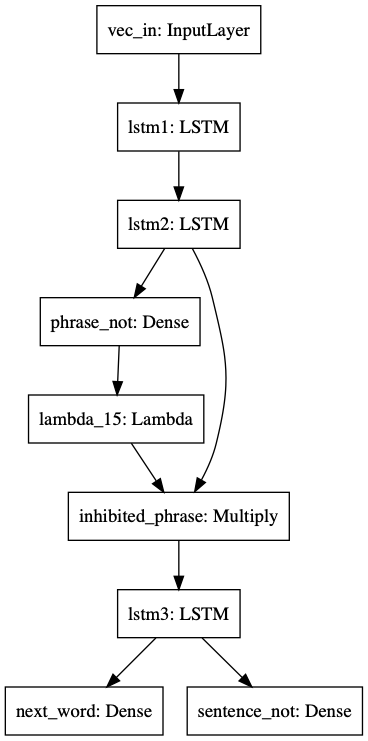

In [47]:
from keras.utils import plot_model
plot_model(model_3, to_file='Data/models/model_3.png')

In [31]:
'''
Specs of model 2 :
 - Takes as input the same structure as model_1 ie.,repeated word embeddings
 - Uses the trained model_1 as one hidden layer
 - takes the hidden state of model_1 (lstm1) as input to another lstm layer
 - the output of lstm_2 is used to predict both p/np and next word.
 - p/np is initialised for first time step
 - The p/np is used as feedback, and multiplied with output from lstm_1
'''
PID = 11
model_1 = load_model(filename_1)
lstm_1_op = model_1.layers[-2].output # use lstm's output
inhibition_signal = K.ones(shape=(1)) 
inhibited_phrase = multiply([lstm_1_op,inhibition_signal],name='inhibited_phrase')
lstm2 = LSTM(100, return_sequences=True, name='lstm2')(inhibited_phrase)
next_word = Dense(334, name='next_word')(lstm2)
phrase_not = Dense(1,name='phrase_not')(lstm2)
abs_phrase_not = Lambda(lambda x : K.clip(x,0.1,.8))(phrase_not)
for i in range(1,20):
    # loop unroll
    inhibition_signal = abs_phrase_not
    

#model_2 = Model(inputs=model_1.inputs,outputs=[next_word,phrase_not])    



'''
n = K.variable(np.ones((20,334)))
lstm_1_op = model_1.layers[-2].output # use lstm's output
inhibited_phrase = Input(shape=(20, 334), dtype='float32', name='inhibited_phrase',tensor=n)
lstm2 = LSTM(100, return_sequences=True, name='lstm2')(inhibited_phrase) # create new lstm layer, supply inhibted output to it
next_word = Dense(334, name='next_word')(lstm2) # the last one is for sentence/not sentence prediction
phrase_or_not = Dense(1,name='phrase_not')(lstm2)
abs_phrase_or_not = Lambda(lambda x : K.clip(x,0.1,.8))(phrase_or_not) # to be used as inhibitory signal, clipped
inhibited_phrase = multiply([lstm_1_op,abs_phrase_or_not],name='inhibited_phrase') # apply inhibitory signal on lstm layer
model_2 = Model(inputs=inhibited_phrase,outputs=[next_word,phrase_or_not])
model_2.summary()
'''
'''
phrase_or_not = initializers.Ones()
abs_phrase_or_not = Lambda(lambda x : K.clip(x,0.1,.8))(phrase_or_not) # to be used as inhibitory signal, clipped
inhibited_op = multiply([lstm_1_op,abs_phrase_or_not],name='inhibited_phrase') # apply inhibitory signal on lstm layer
lstm2 = LSTM(100, return_sequences=True, name='lstm2')(inhibited_op) # create new lstm layer, supply inhibted output to it
next_word = Dense(334, name='next_word')(lstm2) # the last one is for sentence/not sentence prediction
phrase_or_not = Dense(1,name='phrase_not')(lstm2)
model_2 = Model(inputs=model_1.input,outputs=[next_word,phrase_or_not])
#model_2.layers[1].trainable = False # make the two layers(lstm1, and phrase_not) non trainable - keep weights from before
#model_2.layers[2].trainable = False
model_2.summary()
#model_2.compile(loss=['mean_squared_error','binary_crossentropy'], optimizer='adam')

#train_data_gen = participants_gen(p_id=PID,synt_out=False,wave_out=False,train_gen=True,repeat_words=False,train_what='sentence')
#model_2.fit_generator(generator=train_data_gen, steps_per_epoch=100, epochs=10,
#                                         verbose=1)
'''

"\nphrase_or_not = initializers.Ones()\nabs_phrase_or_not = Lambda(lambda x : K.clip(x,0.1,.8))(phrase_or_not) # to be used as inhibitory signal, clipped\ninhibited_op = multiply([lstm_1_op,abs_phrase_or_not],name='inhibited_phrase') # apply inhibitory signal on lstm layer\nlstm2 = LSTM(100, return_sequences=True, name='lstm2')(inhibited_op) # create new lstm layer, supply inhibted output to it\nnext_word = Dense(334, name='next_word')(lstm2) # the last one is for sentence/not sentence prediction\nphrase_or_not = Dense(1,name='phrase_not')(lstm2)\nmodel_2 = Model(inputs=model_1.input,outputs=[next_word,phrase_or_not])\n#model_2.layers[1].trainable = False # make the two layers(lstm1, and phrase_not) non trainable - keep weights from before\n#model_2.layers[2].trainable = False\nmodel_2.summary()\n#model_2.compile(loss=['mean_squared_error','binary_crossentropy'], optimizer='adam')\n\n#train_data_gen = participants_gen(p_id=PID,synt_out=False,wave_out=False,train_gen=True,repeat_words=F

<tf.Tensor 'inhibited_phrase_34/mul:0' shape=(None, 20, 100) dtype=float32>